<a href="https://colab.research.google.com/github/daneelsan/INF648-Project/blob/main/notebooks/entregable-03-grupo-01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importación de librerías

In [82]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler

warnings.filterwarnings("ignore")

# Inicialización de la data



## 1. Lectura de Dataset

In [2]:
# Dataset con el cual entrenaremos nuestro modelo

#Rafael Ballester-Ripoll, Enrique G. Paredes, Renato Pajarola.
#Sobol Tensor Trains for Global Sensitivity Analysis.
#In arXiv Computer Science / Numerical Analysis e-prints, 2017
#(https://128.84.21.199/abs/1712.00233).

#Cedric Nugteren and Valeriu Codreanu. CLTune: A Generic Auto-Tuner for OpenCL Kernels.
#In: MCSoC: 9th International Symposium on Embedded Multicore/Many-core Systems-on-Chip. IEEE, 2015
#(http://ieeexplore.ieee.org/document/7328205/)

raw_data_url = 'https://raw.githubusercontent.com/daneelsan/INF648-Project/main/dataset/sgemm_product.csv'
raw_data = pd.read_csv(raw_data_url);
raw_data.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81


## 2. Exploración de los datos

In [3]:
# Dimension de la data
raw_data.shape

(241600, 18)

In [4]:
# Tipos de datos para cada columna
raw_data.dtypes

MWG            int64
NWG            int64
KWG            int64
MDIMC          int64
NDIMC          int64
MDIMA          int64
NDIMB          int64
KWI            int64
VWM            int64
VWN            int64
STRM           int64
STRN           int64
SA             int64
SB             int64
Run1 (ms)    float64
Run2 (ms)    float64
Run3 (ms)    float64
Run4 (ms)    float64
dtype: object

In [5]:
# Valores estadísticos para cada columna
raw_data.describe()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
count,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000,241600.000000
mean,80.415364,80.415364,25.513113,13.935894,13.935894,17.371126,17.371126,5.000000,2.448609,2.448609,0.500000,0.500000,0.500000,0.500000,217.647852,217.579536,217.532756,217.527669
std,42.469220,42.469220,7.855619,7.873662,7.873662,9.389418,9.389418,3.000006,1.953759,1.953759,0.500001,0.500001,0.500001,0.500001,369.012422,368.677309,368.655118,368.677413
min,16.000000,16.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.290000,13.250000,13.360000,13.370000
25%,32.000000,32.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,40.660000,40.710000,40.660000,40.640000
50%,64.000000,64.000000,32.000000,8.000000,8.000000,16.000000,16.000000,5.000000,2.000000,2.000000,0.500000,0.500000,0.500000,0.500000,69.825000,69.930000,69.790000,69.820000
75%,128.000000,128.000000,32.000000,16.000000,16.000000,32.000000,32.000000,8.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,228.530000,228.310000,228.320000,228.320000
max,128.000000,128.000000,32.000000,32.000000,32.000000,32.000000,32.000000,8.000000,8.000000,8.000000,1.000000,1.000000,1.000000,1.000000,3339.630000,3375.420000,3397.080000,3361.710000


In [6]:
# Valores únicos de cada columna
raw_data.nunique()

MWG              4
NWG              4
KWG              2
MDIMC            3
NDIMC            3
MDIMA            3
NDIMB            3
KWI              2
VWM              4
VWN              4
STRM             2
STRN             2
SA               2
SB               2
Run1 (ms)    58161
Run2 (ms)    58269
Run3 (ms)    58264
Run4 (ms)    58154
dtype: int64

In [7]:
# Existencia de valores nulos para cada columna
raw_data.isnull().any()

MWG          False
NWG          False
KWG          False
MDIMC        False
NDIMC        False
MDIMA        False
NDIMB        False
KWI          False
VWM          False
VWN          False
STRM         False
STRN         False
SA           False
SB           False
Run1 (ms)    False
Run2 (ms)    False
Run3 (ms)    False
Run4 (ms)    False
dtype: bool

## 3. Variables con alta desviación

In [8]:
def graph_dist_column(col):
  print(raw_data[col].sort_values(ascending=True).value_counts(sort = False))
  plt.figure(figsize=(10, 6))
  plt.hist(raw_data[col], bins=100, color='lightgreen', edgecolor='black')
  plt.title('Distribution of ' + col)
  plt.xlabel(col)
  plt.ylabel('Frequency')
  plt.grid(True)
  plt.show()

MWG
16     18944
32     47264
64     75584
128    99808
Name: count, dtype: int64


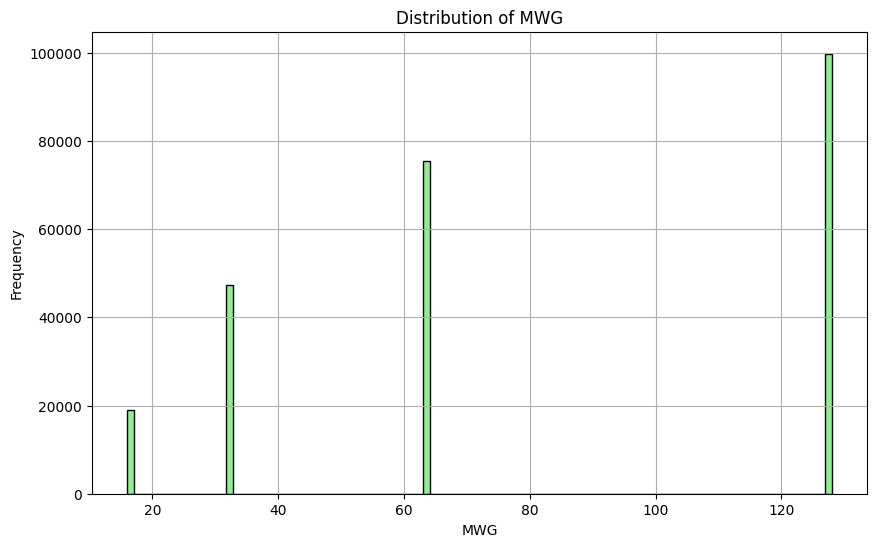

NWG
16     18944
32     47264
64     75584
128    99808
Name: count, dtype: int64


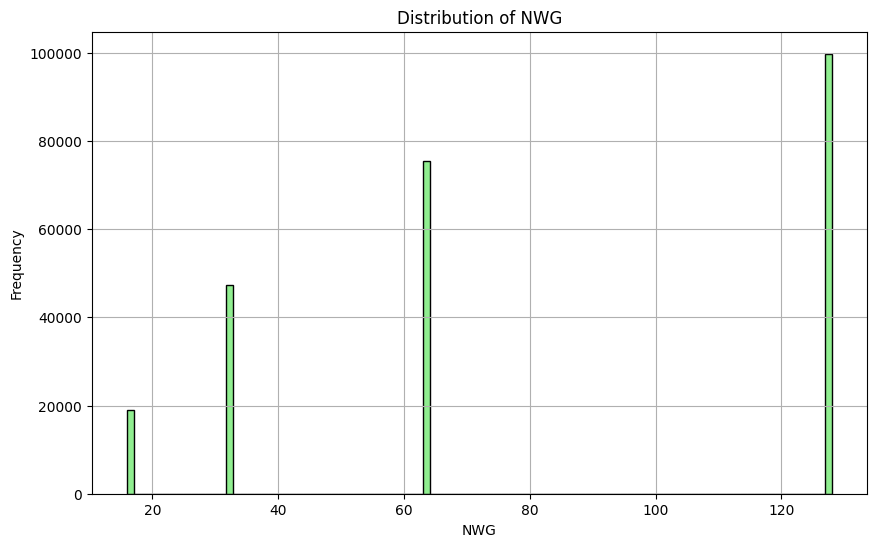

In [9]:
# Se evalúan los valores numéricos con desviación estándar muy alta
graph_dist_column('MWG')
graph_dist_column('NWG')

# Preprocesamiento de datos

## 1. Definir variable objetivo

In [10]:
# Trabajemos con una copia del dataset
data = raw_data;

In [11]:
# Las últimas cuatro columnas son las variables objetivo (Run1 (ms), Run2 (ms), Run3 (ms), Run4 (ms))
# Crear una variable objetivo única como el logaritmo del promedio de estos tiempos de ejecución
data['average_run'] = data[['Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)']].mean(axis=1)
data['log_average_run'] = np.log(data['average_run'])

In [12]:
# Eliminar las columnas de tiempos de ejecución originales y la columna 'average_run'
data = data.drop(columns=['Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)', 'average_run'])

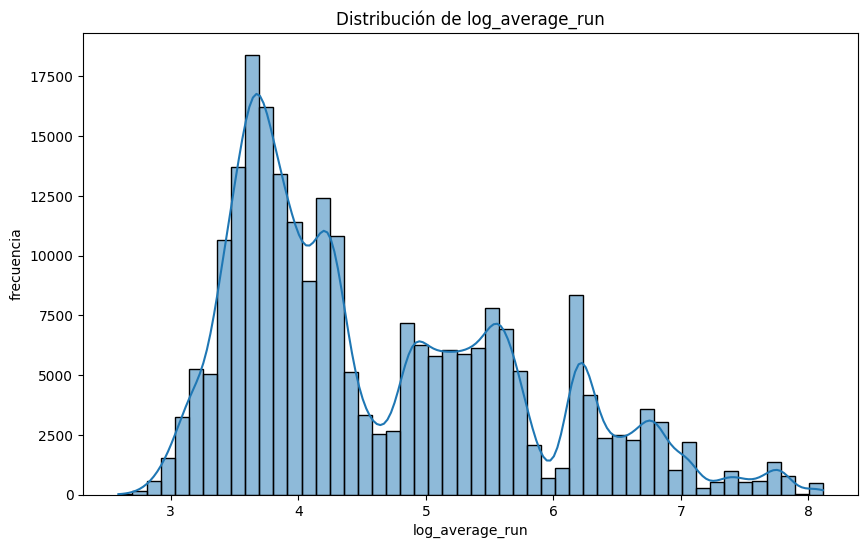

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(data['log_average_run'], bins=50, kde=True)
plt.title('Distribución de log_average_run')
plt.xlabel('log_average_run')
plt.ylabel('frecuencia')
plt.show()

## 2. Separar data de entrenamiento y prueba

In [14]:
# Características y objetivo
X = data.drop(columns=['log_average_run'])
y = data['log_average_run']

In [15]:
X.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0


In [16]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3. Análisis de Componentes Principales

In [17]:
# Estandarizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [18]:
# Aplicar PCA
pca = PCA(n_components=2)  # Reducimos a 2 componentes principales para visualización
X_pca = pca.fit_transform(X_scaled)

In [19]:
# Crear un DataFrame con los resultados de PCA
pca_df = pd.DataFrame(data=X_pca, columns=['Componente Principal 1', 'Componente Principal 2'])
pca_df['LogAvgRunTime'] = y.values

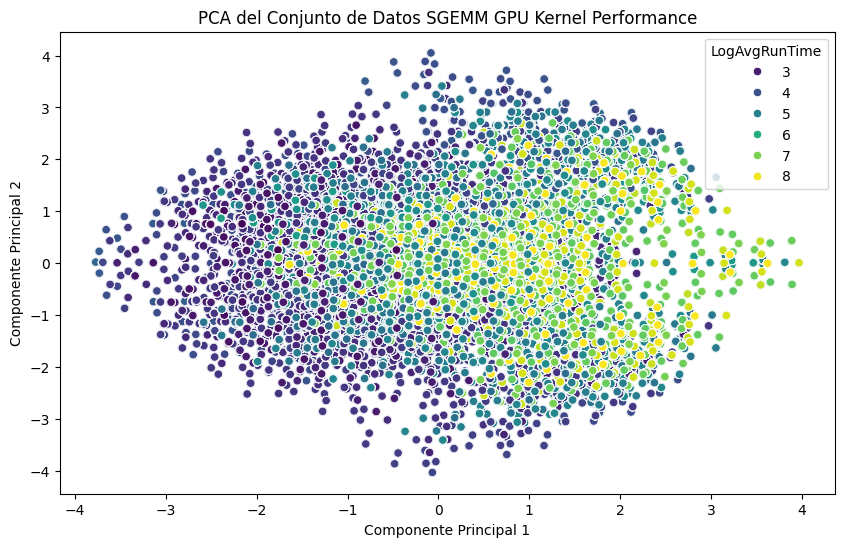

In [22]:
# Visualizar los resultados de PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='Componente Principal 1', y='Componente Principal 2', hue='LogAvgRunTime', palette='viridis')
plt.title('PCA del Conjunto de Datos SGEMM GPU Kernel Performance')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

In [23]:
# Variancia explicada por cada componente principal
explained_variance = pca.explained_variance_ratio_
print(f"Varianza explicada por la primera componente principal: {explained_variance[0]:.2f}")
print(f"Varianza explicada por la segunda componente principal: {explained_variance[1]:.2f}")

Varianza explicada por la primera componente principal: 0.10
Varianza explicada por la segunda componente principal: 0.10


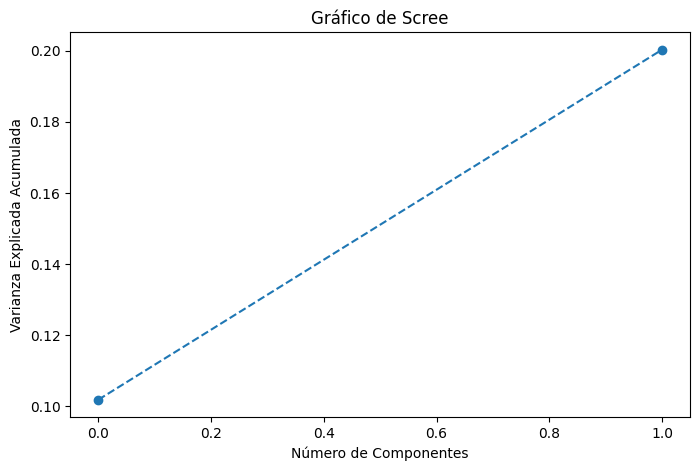

In [24]:
# Gráfico de scree plot
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Gráfico de Scree')
plt.show()

## 4. Identificación de Parámetros Críticos

1.   Entrenamiento de un Modelo de Random Forest: Este modelo es útil porque proporciona una medida directa de la importancia de cada característica.
2.   Cálculo de Importancias de Características: Extraer la importancia de cada característica desde el modelo de Random Forest.

Este análisis nos permitirá identificar cuáles de los 14 parámetros tienen el mayor impacto en el tiempo de ejecución, proporcionando una visión general (con Random Forest).

In [25]:
# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
# Entrenar un modelo de Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [27]:
# Calcular la importancia de las características
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

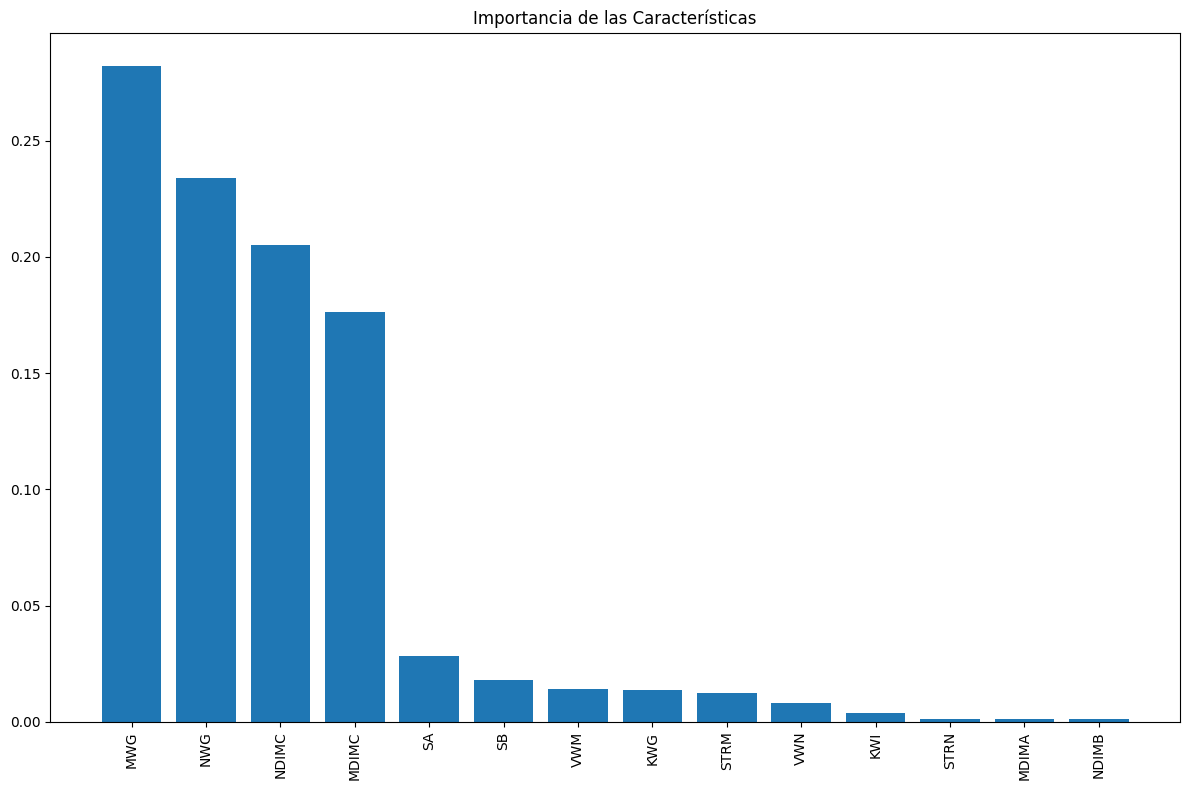

In [28]:
# Visualizar la importancia de las características
plt.figure(figsize=(12, 8))
plt.title('Importancia de las Características')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

# Ejecución de Modelos

In [71]:
#Función para graficar resultados
def plot_model_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title(title)
    plt.show()

# Inicializa dataframe de errores
df_errors = pd.DataFrame({
    'Modelo': [],
    'ECM_train': [],
    'ECM_test': [],
    'R2_train': [],
    'R2_test': []
})

#Función para almacenar errores
def insert_error(model_name, ECM_train, ECM_test, R2_train, R2_test):
    df_errors.loc[df_errors.shape[0]] = [model_name, ECM_train, ECM_test, R2_train, R2_test]

## 1. Regresión Polinómica

Nota: Aumentar el polinomio de mayor grado siempre será escogido por el GridSearchCV.
Overfitting?

In [72]:
# Definir los grados a probar
# (TODO: rename to xxxx_poly)
degrees_poly = [1, 2, 3]
param_grid_poly = {'poly__degree': degrees_poly}

In [73]:
# Crear un pipeline para la regresión polinómica
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()), #Estandarizar variables
    ('regressor', LinearRegression()) #Regresión
])

In [74]:
# Realizar la búsqueda de cuadrícula para encontrar el mejor grado de polinomio
grid_search_poly = GridSearchCV(pipeline, param_grid_poly, cv=5, scoring='neg_mean_squared_error', verbose=3)
grid_search_poly.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ...................poly__degree=1;, score=-0.562 total time=   0.3s
[CV 2/5] END ...................poly__degree=1;, score=-0.561 total time=   0.3s
[CV 3/5] END ...................poly__degree=1;, score=-0.554 total time=   0.2s
[CV 4/5] END ...................poly__degree=1;, score=-0.564 total time=   0.2s
[CV 5/5] END ...................poly__degree=1;, score=-0.556 total time=   0.2s
[CV 1/5] END ...................poly__degree=2;, score=-0.237 total time=   3.8s
[CV 2/5] END ...................poly__degree=2;, score=-0.239 total time=   3.9s
[CV 3/5] END ...................poly__degree=2;, score=-0.237 total time=   5.1s
[CV 4/5] END ...................poly__degree=2;, score=-0.237 total time=   4.2s
[CV 5/5] END ...................poly__degree=2;, score=-0.237 total time=   5.5s
[CV 1/5] END ...................poly__degree=3;, score=-0.153 total time=  26.8s
[CV 2/5] END ...................poly__degree=3;, 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('regressor', LinearRegression())]),
             param_grid={'poly__degree': [1, 2, 3]},
             scoring='neg_mean_squared_error', verbose=3)

In [76]:
#Se capturan las predicciones del modelo
y_pred_train_poly = grid_search_poly.predict(X_train)
y_pred_test_poly = grid_search_poly.predict(X_test)

In [77]:
print("Mejor grado de polinomio:", grid_search_poly.best_params_['poly__degree'])

#Almacenamos errores
insert_error('Regresión Polinómica', mean_squared_error(y_train, y_pred_train_poly), mean_squared_error(y_test, y_pred_test_poly), r2_score(y_train, y_pred_train_poly), r2_score(y_test, y_pred_test_poly))
print("Error cuadrático medio (entrenamiento):", df_errors.iloc[-1]['ECM_train'])
print("Error cuadrático medio (prueba):", df_errors.iloc[-1]['ECM_test'])
print("Coeficiente de determinación R^2 (entrenamiento):", df_errors.iloc[-1]['R2_train'])
print("Coeficiente de determinación R^2 (prueba):", df_errors.iloc[-1]['R2_test'])

Mejor grado de polinomio: 3
Error cuadrático medio (entrenamiento): 0.15124044529105887
Error cuadrático medio (prueba): 0.1518347090939334
Coeficiente de determinación R^2 (entrenamiento): 0.8815414298917098
Coeficiente de determinación R^2 (prueba): 0.8795845815293691


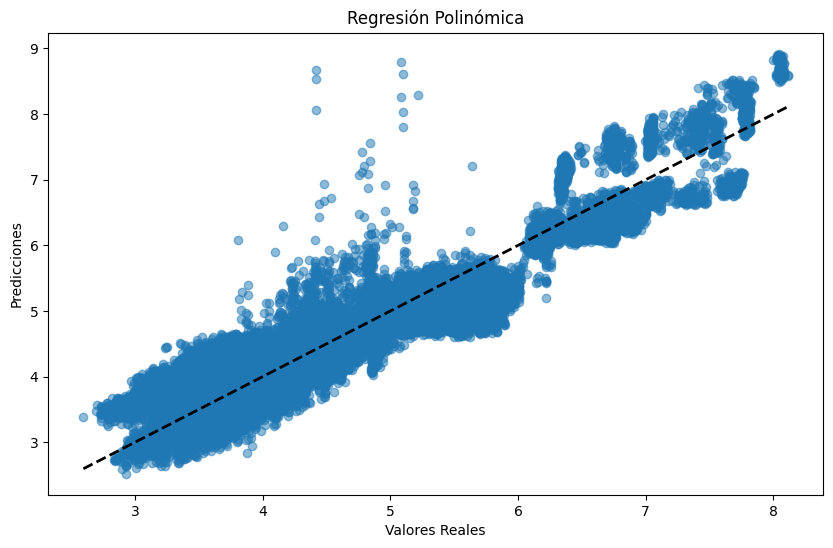

In [ ]:
plot_model_predictions(y_test, y_pred_test_poly, 'Regresión Polinómica')

## 2. Random Forest

In [80]:
#Se definen los parámetros para el Random Forest
param_grid_rf = {
    'n_estimators': [100, 200], #Número de árboles
    'max_depth': [10, 20, 30] #Profundidad máxima
}

In [83]:
#Entrena el modelo
n_cv = KFold(n_splits=5) #Número de pliegues
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=n_cv, scoring='neg_mean_squared_error', verbose=3)
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...max_depth=10, n_estimators=100;, score=-0.026 total time=  23.0s
[CV 2/5] END ...max_depth=10, n_estimators=100;, score=-0.027 total time=  33.6s
[CV 3/5] END ...max_depth=10, n_estimators=100;, score=-0.027 total time=  36.2s
[CV 4/5] END ...max_depth=10, n_estimators=100;, score=-0.026 total time=  23.7s
[CV 5/5] END ...max_depth=10, n_estimators=100;, score=-0.027 total time=  23.6s
[CV 1/5] END ...max_depth=10, n_estimators=200;, score=-0.025 total time=  56.9s
[CV 2/5] END ...max_depth=10, n_estimators=200;, score=-0.027 total time=  47.4s
[CV 3/5] END ...max_depth=10, n_estimators=200;, score=-0.026 total time=  47.2s
[CV 4/5] END ...max_depth=10, n_estimators=200;, score=-0.026 total time=  47.4s
[CV 5/5] END ...max_depth=10, n_estimators=200;, score=-0.027 total time=  45.8s
[CV 1/5] END ...max_depth=20, n_estimators=100;, score=-0.001 total time=  45.6s
[CV 2/5] END ...max_depth=20, n_estimators=100;, 

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [10, 20, 30], 'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error', verbose=3)

In [84]:
#Se capturan las predicciones del modelo
y_pred_train_rf = grid_search_rf.predict(X_train)
y_pred_test_rf = grid_search_rf.predict(X_test)

In [85]:
print("Mejores parámetros (Random Forest):", grid_search_rf.best_params_)

#Almacenamos errores
insert_error('Regresión Polinómica', mean_squared_error(y_train, y_pred_train_rf), mean_squared_error(y_test, y_pred_test_rf), r2_score(y_train, y_pred_train_rf), r2_score(y_test, y_pred_test_rf))
print("Error cuadrático medio (entrenamiento):", df_errors.iloc[-1]['ECM_train'])
print("Error cuadrático medio (prueba):", df_errors.iloc[-1]['ECM_test'])
print("Coeficiente de determinación R^2 (entrenamiento):", df_errors.iloc[-1]['R2_train'])
print("Coeficiente de determinación R^2 (prueba):", df_errors.iloc[-1]['R2_test'])

Mejores parámetros (Random Forest): {'max_depth': 30, 'n_estimators': 200}
Error cuadrático medio (entrenamiento): 0.00010199739033234488
Error cuadrático medio (prueba): 0.0007653343957012946
Coeficiente de determinación R^2 (entrenamiento): 0.9999201108870693
Coeficiente de determinación R^2 (prueba): 0.9993930369276018


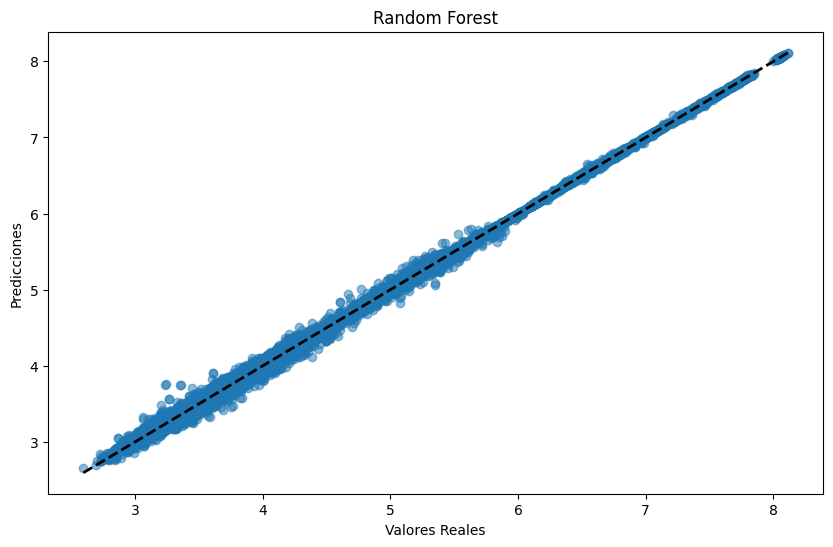

In [86]:
plot_model_predictions(y_test, y_pred_test_rf, 'Random Forest')

## 3. Regresión Logística

No tiene sentido ya que no queremos clasificar data

In [ ]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train > y_train.median())  # Clasificación binaria basada en la mediana del tiempo de ejecución

LogisticRegression(max_iter=1000)

In [ ]:
y_pred_train_log = log_reg.predict(X_train)
y_pred_test_log = log_reg.predict(X_test)

In [ ]:
print("Precisión (entrenamiento):", log_reg.score(X_train, y_train > y_train.median()))
print("Precisión (prueba):", log_reg.score(X_test, y_test > y_test.median()))

Precisión (entrenamiento): 0.8098716887417219
Precisión (prueba): 0.8104304635761589


## Gráficos

Faltan gráficas comparando los modelos.

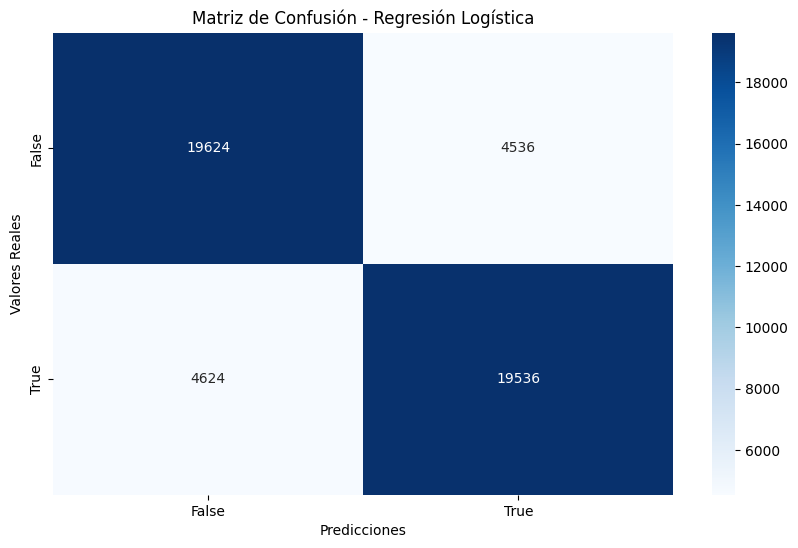

In [ ]:
# Gráfico de resultados de regresión logística
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(y_test > y_test.median(), y_pred_test_log), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Regresión Logística')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()